# 0. Marking.

***IMPORTANT***: Save a copy of this notebook into your Drive before you start.
- Please attempt all the questions marked for your group (Part II ✅ | Part III/MPhil ✅).
- Continue to part 2 after you are done with this one.

Please submit a zip file, containing both parts, consiting of of:
1. A text file with a publicly visible link to your notebooks in Google Colab or GitHub.
2. A downloaded copy (ipynb) of your notebooks or your zipped cloned GitHub repo. You may treat these as a report: we will not be re-executing the code you used to produce the answers unless required.

If you find yourself enjoying the material, feel free to attempt more! Provide your answers in a new cell below the question cell.

### Globals.


In [1]:
# The simulation component of the flower framework uses RAY under the hood.
# `pip` could produce some errors. Do not worry about them.
# The execution has been verified; it's working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet git+https://github.com/Iacob-Alexandru-Andrei/flower.git@teaching torch torchvision matplotlib gdown tqdm ray=="2.6.3" seaborn
# The following is just needed to show the folder tree

In [2]:
from typing import *

### Imports.


In [3]:
## Imports

import csv
import numbers
import os
import random
from collections import OrderedDict, defaultdict
from copy import deepcopy
from pathlib import Path

import flwr as fl
import gdown
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.common import Metrics
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig, History
from flwr.client import Client
from flwr.server.strategy import FedAvgM as FedAvg, Strategy
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum
from datetime import datetime
from datetime import timezone
import json
from flwr.server import ServerConfig
from typing import Optional, Union


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337


np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore


def convert(o):
    if isinstance(o, np.int64) or isinstance(o, np.int32):
        return int(o)
    if isinstance(o, np.float32) or isinstance(o, np.float64):
        return float(o)
    raise TypeError


def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT, **kwargs):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)


PathType = Optional[Union[Path, str]]


def get_device() -> str:
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

/home/markhaoxiang/Projects/fl/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-03 18:50:24,691	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
home_dir = content if (content := Path("/content")).exists() else Path.cwd()
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / "client_data_mappings" / "centralized"
centralized_mapping: Path = dataset_dir / "client_data_mappings" / "centralized" / "0"
federated_partition: Path = dataset_dir / "client_data_mappings" / "fed_natural"

#  Download compressed dataset
if not (home_dir / "femnist.tar.gz").exists():
    id = "1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist.tar.gz"),
    )

# Decompress dataset
if not dataset_dir.exists():
    !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
    print(f"Dataset extracted in {dataset_dir}")

In [5]:
if not (home_dir / "common").exists():
    ! git clone "https://github.com/camlsys/L361-Federated-Learning.git" temp_repo

    # Copy the folder to the current directory
    ! cp -r "temp_repo/labs/common" {home_dir}

    # Delete the cloned repository
    ! rm -rf temp_repo

(home_dir / "__init.py").open(mode="a+")

<_io.TextIOWrapper name='/home/markhaoxiang/Projects/fl/lab1/__init.py' mode='a+' encoding='UTF-8'>

In [6]:
from common.femnist_dataset import FEMNIST

from common.client_utils import (
    Net,
    load_FEMNIST_dataset,
    get_network_generator_cnn as get_network_generator,
    train_FEMNIST,
    test_FEMNIST,
)

# 5. Building a Flower FL client.

Our first client abstraction shall be as simple as possible and will require adjustment to match the structure that the flower framework expects. However, it shall be conceptually identical and require only light API changes.

Moving from centralised ML to server-client FL requires us to provide a means of communication between the respective server and clients. The Flower Framework is ML-framework agnostic and allows various means of transmitting model parameters in the federated network. Since you may have limited resources in these labs, we will only tangentially follow the Flower framework while keeping the computational requirements to a minimum.

The simplest and most common encoding for models is the mere transmission of model parameters as NumPy arrays instead of the stateful PyTorch models. The following functions allow for seamless conversions between the two.

In [7]:
def set_model_parameters(net: Module, parameters: NDArrays) -> Module:
    """Function to put a set of parameters into the model object.

    Args:
        net (Module): model object.
        parameters (NDArrays): set of parameters to put into the model.

    Returns:
        Module: updated model object.
    """
    weights = parameters
    params_dict = zip(net.state_dict().keys(), weights)
    state_dict = OrderedDict({k: torch.from_numpy(np.copy(v)) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)
    return net


def get_model_parameters(net: Module) -> NDArrays:
    """Function to get the current model parameters as NDArrays.

    Args:
        net (Module): current model object.

    Returns:
        NDArrays: set of parameters from the current model.
    """
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

With them in place, making the client abstraction compatible with Flower requires only a bit of boilerplate such as allowing NumPy arrays to be received and sent instead of PyTorch models. To achieve this, we provide a model generator capable of creating a network and using the received parameters.

To keep client objects light in the memory when not used by the Flower FL simulator, the model generator is only called as needed for either `fit` or `evaluate`.

In [8]:
class FlowerRayClient(fl.client.NumPyClient):
    def __init__(
        self,
        cid: int,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        """Function to initialise the client with its unique id
        and the directory from which it can load its data.

        Args:
            cid (int): Unique client id for a client used to map it to its data partition
            partition_dir (Path): The directory containing data for each client/client id
            model_generator (Callable[[], Module]): The model generator function
        """
        self.cid = cid
        print("cid: ", self.cid)
        self.partition_dir = partition_dir
        self.device = str(
            torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        )
        self.model_generator: Callable[[], Module] = model_generator
        self.properties: Dict[str, Scalar] = {"tensor_type": "numpy.ndarray"}

    def set_parameters(self, parameters: NDArrays) -> Module:
        """Loads weights inside the network.

        Args:
            parameters (NDArrays): set of weights to be loaded.

        Returns:
            [Module]: Network with new set of weights.
        """
        net = self.model_generator()
        return set_model_parameters(net, parameters)

    def get_parameters(self, config: Dict[int, Scalar]) -> NDArrays:
        """Returns weights from a given model. If no model is passed, then a
        local model is created. This can be used to initialise a model in the
        server.
        The config param is not used but is mandatory in Flower.

        Args:
            config (Dict[int, Scalar]): dictionary containing configuration info.

        Returns:
            NDArrays: weights from the model.
        """
        net = self.model_generator()
        return get_model_parameters(net)

    def fit(
        self, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Tuple[NDArrays, int, dict]:
        """Function which receives and trains a model on the local client data using parameters from the config dict

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the training parameters

        Returns:
            Tuple[NDArrays, int, dict]: Returns the updated model, the size of the local dataset and other metrics
        """

        # Only create model right before training/testing
        # To lower memory usage when idle
        net = self.set_parameters(parameters)
        net.to(self.device)

        train_loader: DataLoader = self._create_data_loader(config, name="train")
        train_loss = self._train(net, train_loader=train_loader, config=config)
        return get_model_parameters(net), len(train_loader), {"train_loss": train_loss}

    def evaluate(
        self, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Tuple[float, int, dict]:
        """Function which receives and tests a model on the local client data using parameters from the config dict

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the testing parameters

        Returns:
            Tuple[float, int, dict]: Returns the loss accumulate during testing, the size of the local dataset and other metrics such as accuracy
        """
        net = self.set_parameters(parameters)
        net.to(self.device)

        test_loader: DataLoader = self._create_data_loader(config, name="test")
        loss, accuracy = self._test(net, test_loader=test_loader, config=config)
        return loss, len(test_loader), {"local_accuracy": accuracy}

    def _create_data_loader(self, config: Dict[str, Scalar], name: str) -> DataLoader:
        """Creates the data loader using the specified config parameters

        Args:
            config (Dict[str, Scalar]): Dictionary containing dataloader and dataset parameters
            mode (str): Load the training or testing set for the client

        Returns:
            DataLoader: A pytorch dataloader iterable for training/testing
        """
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name)
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name) -> Dataset:
        full_file: Path = self.partition_dir / str(self.cid)
        return load_FEMNIST_dataset(
            mapping=full_file,
            name=name,
            data_dir=data_dir,
        )

    def _train(
        self, net: Module, train_loader: DataLoader, config: Dict[str, Scalar]
    ) -> float:
        return train_FEMNIST(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=config["max_batches"],
        )

    def _test(
        self, net, test_loader: DataLoader, config: Dict[str, Scalar]
    ) -> Tuple[float, float]:
        return test_FEMNIST(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
            max_batches=config["max_batches"],
        )

    def get_properties(self, config: Dict[str, Scalar]) -> Dict[str, Scalar]:
        """Returns properties for this client.

        Args:
            config (Dict[str, Scalar]): Options to be used for selecting specific
            properties.

        Returns:
            Dict[str, Scalar]: Returned properties.
        """
        # pylint: disable=unused-argument
        return self.properties

    def get_train_set_size(self) -> int:
        """Returns the client train set size.

        Returns:
            int: train set size of the client.
        """
        return len(self._load_dataset("train"))  # type: ignore

    def get_test_set_size(self) -> int:
        """Returns the client test set size.

        Returns:
            int: test set size of the client.
        """
        return len(self._load_dataset("test"))  # type: ignore

The underlying FL simulator used by Flower is based on [Ray](https://www.ray.io/). It expects each client only to require a client ID for instantiation. Therefore, using the following generator function, we can determine the specific network used for FL together with the FEMNIST partition to which the `cid` refers.

While we will not use `Ray` in this lab due to its heavyweight nature, we will keep all code API compatible with the default flower framework.

In [9]:
def get_flower_client_generator(
    model_generator: Callable[[], Module],
    partition_dir: Path,
    mapping_fn: Optional[Callable[[int], int]] = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to be of type str.

        Returns:
            FlowerRayClient: client instance.
        """
        return FlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

To ensure the Flower client behaves the same as our simple demo client, a simple test using the centralised partition we defined earlier should suffice.

In [10]:
network_generator = get_network_generator()
seed_net: Net = network_generator()
seed_model_params: NDArrays = get_model_parameters(seed_net)

centralized_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_flower_client_generator(network_generator, centralized_partition)  # type: ignore
centralized_flower_client = centralized_flower_client_generator(0)

cid:  0


In [11]:
centralized_train_config: Dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": 100,
}

test_config: Dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 2,
    "max_batches": 100,
}

# Train parameters on the centralised dataset
trained_params, num_examples, train_metrics = fit_client_seeded(
    centralized_flower_client, params=seed_model_params, conf=centralized_train_config
)
print(train_metrics)

{'train_loss': 0.11736562751233577}


In [12]:
# Test trained parameters on the centralised dataset
loss, num_examples, test_metrics = centralized_flower_client.evaluate(
    parameters=trained_params, config=test_config
)
print(loss, test_metrics)

  0%|          | 0/2329 [00:00<?, ?it/s]

  4%|▍         | 100/2329 [00:00<00:08, 262.28it/s]

369.5580060482025 {'local_accuracy': 0.059375}


# 6. FL with natural partitions

Given its naturally-partitioned nature, we can easily construct a realistic FL experiment by mapping clients one-to-one with the writers of the original symbols.

To pursue this aim, we shall use the “naturally federated” partition instead of the "centralised” one. We are then using the entire `train.csv` and `test.csv` contained in the subfolders of `client_data_mappings/fed_natural`. Each subfolder is named after the clients' ID in the dataset, i.e., from `0` to `3229`.

To guarantee that each client has sufficient training data to participate meaningfully, a common practice is to set a lower bound on the number of samples a selected client is allowed to have. Generally, this threshold should be equivalent to at least one batch. We will now implement a function to sample clients from the federation that satisfies the abovementioned filter in the train set.

In [13]:
def sample_random_clients(
    total_clients: int,
    filter_less: int,
    partition: Path,
    seed: Optional[int] = Seeds.DEFAULT,
) -> Sequence[int]:
    """Function to randomly sample clients.
    A filter on the client train set size is performed.

    Args:
        total_clients (int): total number of clients to sample.
        filter_less (int): max number of train samples for which the client is **discarded**.
        partition (Path): path to the folder containing the partitioning.
        seed (Optional[int], optional): seed for the random generator. Defaults to None.

    Returns:
        Sequence[int]: list of sample client ids as int.
    """
    real_federated_cid_client_generator: Callable[
        [int], FlowerRayClient
    ] = get_flower_client_generator(network_generator, federated_partition)  # type: ignore
    if seed is not None:
        random.seed(seed)
    list_of_ids = []
    while len(list_of_ids) < total_clients:
        current_id = random.randint(0, 3229)
        if (
            real_federated_cid_client_generator(current_id).get_train_set_size()
            > filter_less
        ):
            list_of_ids.append(current_id)
    return list_of_ids

While FEMNIST has more than 3000 clients, our small-scale experiments will not require more than 100 at any point.

In [14]:
total_clients: int = 100
list_of_ids = sample_random_clients(
    total_clients, centralized_train_config["batch_size"], federated_partition
)

federated_client_generator: Callable[
    [int], FlowerRayClient
] = get_flower_client_generator(
    network_generator, federated_partition, lambda seq_id: list_of_ids[seq_id]
)  # type: ignore

cid:  2530
cid:  2184
cid:  2907
cid:  1498
cid:  2338
cid:  2399
cid:  2997
cid:  678
cid:  3175
cid:  1363
cid:  1571
cid:  2600
cid:  1473
cid:  1260
cid:  1603
cid:  2855
cid:  839
cid:  3119
cid:  2688
cid:  1494
cid:  447
cid:  1742
cid:  2601
cid:  1633
cid:  267
cid:  2070
cid:  2863
cid:  2736
cid:  1425
cid:  1653
cid:  1652
cid:  3020
cid:  1273
cid:  2718
cid:  73
cid:  1446
cid:  2434
cid:  485
cid:  1887
cid:  1009
cid:  701
cid:  1285
cid:  2782
cid:  2828
cid:  2476
cid:  1872
cid:  2471
cid:  1084
cid:  823
cid:  2243
cid:  275
cid:  2614
cid:  2152
cid:  2534
cid:  2364
cid:  3168
cid:  179
cid:  295
cid:  1668
cid:  2674
cid:  2538
cid:  220
cid:  2767
cid:  70
cid:  2600
cid:  806
cid:  807
cid:  428
cid:  1167
cid:  805
cid:  1852
cid:  3068
cid:  2329
cid:  1287
cid:  51
cid:  2501
cid:  1366
cid:  1770
cid:  2343
cid:  937
cid:  2251
cid:  187
cid:  3178
cid:  2274
cid:  2975
cid:  2645
cid:  1258
cid:  875
cid:  2504
cid:  740
cid:  2167
cid:  2157
cid:  2164
ci

Now, to test that the newly partitioned clients can be trained.

In [15]:
one_epoch_config: Dict[str, Any] = {
    "epochs": 1,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": 100,
}

test_config: Dict[str, Any] = {
    "batch_size": 32,
    "num_workers": 2,
    "max_batches": 100,
}

In [16]:
num_clients = 4
clients = random.sample(list(range(0, total_clients)), num_clients)

In [17]:
trained_models = [
    fit_client_seeded(
        federated_client_generator(cid), seed_model_params, one_epoch_config
    )
    for cid in clients
]

cid:  3175
cid:  51
cid:  1668
cid:  1498


In [18]:
trained_model_parameters = [model for model, *rest in trained_models]
trained_model_metrics = [rest for _, *rest in trained_models]
print(trained_model_metrics)

[[4, {'train_loss': 0.12444548681378365}], [11, {'train_loss': 0.12350456416606903}], [3, {'train_loss': 0.12324738750855128}], [4, {'train_loss': 0.12358858622610569}]]


**Question 5 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

If we index the weights of an ML model consecutively, with the assumed architecture being the same, we can visualize it as a single flattened 1-D vector. One, highly imperfect, metric for determining how similar two ML models are is cosine similarity. We can use this metric to compare the models our clients produce are.

1. Write functions to:
    - Flatten the `NDArrays` objects into a single 1-D vector.
    - Compute the cosine similarity of two 1-D vectors based on their inner product and norms.
2. Compute a similarity matrix between all client models and plot it.
3. What happens to the similarity matrix if you increase the number of local epochs that clients train for to 5 from 1? Why do you think that is?
>You may want to save the parameters calculated here separately from the default ones as both sets will be needed in future questions.

In [19]:
def flatten(*models) -> List[np.ndarray]:
    """ Flatten the NDArrays objects into a single 1-D vectors

    Returns:
        List[np.ndarray]: A list of 1-D vectors, each item representing a model
    """
    flattened_models = []
    for i, model in enumerate(models):
        flattened_model = []
        for j, layer in enumerate(model):
            flattened_model.append(layer.flatten())
        flattened_models.append(np.concatenate(flattened_model, axis=0))
    return flattened_models

def cosine_similarity(a: np.ndarray, b: np.ndarray):
    """ Computes the cosine similarity of two 1-D vectors based on their inner products and norms

    Args:
        a (np.ndarray): First vector
        b (np.ndarray): Second vector
    """
    assert a.shape == b.shape and len(a.shape) == 1, "Input tensors are not of the correct dimension"
    return a.T @ b / ((a.T @ a)**0.5 * (b.T @ b)**0.5)


In [20]:
# Repeat experiment with 5 epochs
five_epoch_config: Dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 2,
    "max_batches": 100,
}

clients_five = random.sample(list(range(0, total_clients)), num_clients)
trained_models_five = [
    fit_client_seeded(
        federated_client_generator(cid), seed_model_params, five_epoch_config
    )
    for cid in clients_five
]
trained_model_parameters_five = [model for model, *rest in trained_models_five]
trained_model_metrics_five = [rest for _, *rest in trained_models_five]

# Save Calculated parameters
question_5_one_epoch_parameters = deepcopy(trained_model_parameters)

cid:  937
cid:  1167
cid:  2167
cid:  2471


3. What happens to the similarity matrix if you increase the number of local epochs that clients train for to 5 from 1? Why do you think that is?

As the visualisation below shows, the similarity of the different models all decrease when increasing the number of training epochs from 1 to 5. This is because the different clients have different convergence targets, and thus the gradient descent brings the vectors towards different directions. Naturally, the models diverge.

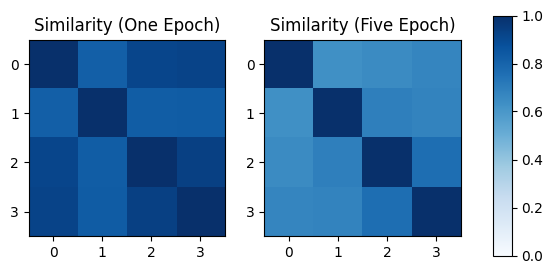

In [21]:
# Calculate Similarity Matrix

# Preprocess
flattened_models_ones = flatten(*trained_model_parameters)
similarity_matrix_ones = np.zeros((num_clients, num_clients))
for i, row in enumerate(similarity_matrix_ones):
    for j, col in enumerate(similarity_matrix_ones):
        similarity_matrix_ones[i,j] = cosine_similarity(flattened_models_ones[i], flattened_models_ones[j])

flattened_models_fives = flatten(*trained_model_parameters_five)
similarity_matrix_fives = np.zeros((num_clients, num_clients))
for i, row in enumerate(similarity_matrix_fives):
    for j, col in enumerate(similarity_matrix_fives):
        similarity_matrix_fives[i,j] = cosine_similarity(flattened_models_fives[i], flattened_models_fives[j])

# Visualisation
fig, axs = plt.subplots(1,2)
    # One epoch
ax = axs[0]
ax.set_title("Similarity (One Epoch)")
ax.imshow(similarity_matrix_ones, cmap="Blues", norm=None, vmin=0, vmax=1)
ax.set_xticks([0,1,2,3])
ax.set_yticks([0,1,2,3])

    # Five epochs
ax = axs[1]
ax.set_title("Similarity (Five Epoch)")
im = ax.imshow(similarity_matrix_fives, cmap="Blues", norm=None, vmin=0, vmax=1)
ax.set_xticks([0,1,2,3])
ax.set_yticks([0,1,2,3])

    # Colorbar
from matplotlib import cm
fig.subplots_adjust(right=0.8)
colorbar_axes = fig.add_axes([0.85,0.25,0.03,0.5])
fig.colorbar(cm.ScalarMappable(norm=None, cmap="Blues"), cax=colorbar_axes)

**Question 6 (Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

One reason that cosine similarity is an imperfect metric is because it considers weights from different layers to be equally important to the model in terms of its behavior and performance. We can thus create a slightly more detailed picture by tracking the cosine similarity across layers.

1. Create a function which computes the pairwise cosine similarity between flattened model layers across clients, i.e. the cosine similarity between the flattened $l_i$ in `client_x` and the flattened $l_i$ in `client_y`.
2. Plot the similarity of the models at each layer between the most similar client pair and the most disimilar client pair (as determined by the multi-epoch experiment) using the **one-epoch models**, how do the curves you observe relate to the general cosine similarity you computed for the flattened models.
3. What happens to the curves if you increase the number of local epochs to 5? How does this behavior relate to what you observed in the previous exercise ?
4. **Optional**: Do you think there is any connection to the underlying architecture? Why? Repeat the above experiments using an MLP such as the one provided by the  `get_network_generator_mlp` in `client_utils` and compare results against the CNN.

# 7. Federated training with Flower

The two basic blocks of synchronous server-client FL systems are:
- A client with some local training method and data---i.e., SGD. This is what we have built thus far.
- A server which coordinates training sends the federated model to clients at the start of each round and aggregates model updates at the end of each round.


![picture](https://drive.google.com/uc?id=1Db_Uys2QPFHW6cMranZ_QXo2vC0A_C-N)

While the variety of client local training methods is as wide as ML, server training varies depending on which **aggregation algorithm** combines the model updates and forms the new federated model. Flower refers to the component that controls the aggregation and train/test configuration as a **strategy**. For our labs, strategy and aggregation algorithms will be used interchangeably.

The strategy we shall use is [FedAvg](https://arxiv.org/abs/1602.05629):

$G^{r+1} = G^{r} + \eta \left( \sum_{k=1}^{m} p_k G^r_k \right)$,

where $G^{r+1}$ is the model for the next round, which is formed by applying a model update to the current round model $G^{r}$ weighted by the aggregation learning rate $\eta$. The model update is constructed by a sum of client models $G^{r}_k$ where each client model is weighted by $p_k$. The weight factor is usually set to $p_k = \tfrac{n_k}{N}$---the number of training examples held by said client divided by the example count of each client in the round $N = \sum_{k=1}^{m} n_k$.



**Question 7 (Part II ✅ | Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)

Averaging models is meant to provide us with a reasonable compromise between the desired models of all clients involved. Given what you already know about the similarity of client models, we can test if this is true.
1. Write a function to compute the weighted average of several `NDArrays` objects while preserving the layer-structure. Use the FedAvg equation above with $p_k = \tfrac{n_k}{N}$.
2. Compute the average model of the client models above, both the one-epoch and multi-epoch ones.
3. Add the averaged models to the cosine-similarity matrices built above, how does it relate to the client models?

In [22]:
trained_model_metrics

[[4, {'train_loss': 0.12444548681378365}],
 [11, {'train_loss': 0.12350456416606903}],
 [3, {'train_loss': 0.12324738750855128}],
 [4, {'train_loss': 0.12358858622610569}]]

In [54]:
def weighted_average(numbers: np.ndarray, arrays: np.ndarray):
    N =  numbers.sum()
    weights = (numbers / N)[:, np.newaxis]
    result =  (weights * arrays).sum(axis=0)
    return result


# Calculation

    # Directly operate on the flattened models for later visualisation
aggregated_model_parameters_one = weighted_average(
    numbers = np.array([x[0] for x in trained_model_metrics]),
    arrays = np.array(flattened_models_ones)
)

aggregated_model_parameters_five = weighted_average(
    numbers = np.array([x[0] for x in trained_model_metrics_five]),
    arrays = np.array(flattened_models_fives)
)


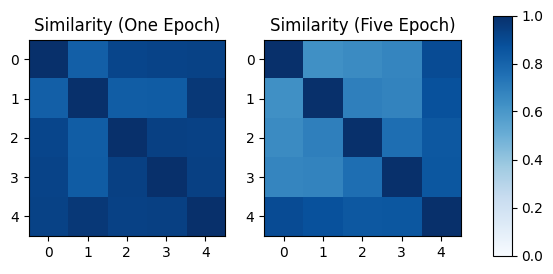

In [55]:
# Visualisation
# Calculate Similarity Matrix

# Preprocess
flattened_models_ones_averaged = flattened_models_ones + [aggregated_model_parameters_one]
similarity_matrix_ones = np.zeros((num_clients+1, num_clients+1))
for i, row in enumerate(similarity_matrix_ones):
    for j, col in enumerate(similarity_matrix_ones):
        similarity_matrix_ones[i,j] = cosine_similarity(flattened_models_ones_averaged[i], flattened_models_ones_averaged[j])

similarity_matrix_fives = np.zeros((num_clients+1, num_clients+1))
flattened_models_fives_averaged = flattened_models_fives + [aggregated_model_parameters_five]
for i, row in enumerate(similarity_matrix_fives):
    for j, col in enumerate(similarity_matrix_fives):
        similarity_matrix_fives[i,j] = cosine_similarity(flattened_models_fives_averaged[i], flattened_models_fives_averaged[j])

# Visualisation
fig, axs = plt.subplots(1,2)
    # One epoch
ax = axs[0]
ax.set_title("Similarity (One Epoch)")
ax.imshow(similarity_matrix_ones, cmap="Blues", norm=None, vmin=0, vmax=1)
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])

    # Five epochs
ax = axs[1]
ax.set_title("Similarity (Five Epoch)")
im = ax.imshow(similarity_matrix_fives, cmap="Blues", norm=None, vmin=0, vmax=1)
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])

    # Colorbar
from matplotlib import cm
fig.subplots_adjust(right=0.8)
colorbar_axes = fig.add_axes([0.85,0.25,0.03,0.5])
fig.colorbar(cm.ScalarMappable(norm=None, cmap="Blues"), cax=colorbar_axes)

In [56]:
# 3. Add the averaged models to the cosine-similarity matrices built above, how does it relate to the client models?

if similarity_matrix_ones.mean(0).argmax() == 4:
    print("Averaged model shares highest similarity to other client models (1 epochs)")
if similarity_matrix_fives.mean(0).argmax() == 4:
    print("Averaged model shares highest similarity to other client models (5 epochs)")

# It can be observed from the diagram that the averaged model shares a high similarity to each individual client model.

Averaged model shares highest similarity to other client models (1 epochs)
Averaged model shares highest similarity to other client models (5 epochs)


**Question 8 (Part III/MPhil ✅):**

(You need to provide the answer with **code** for this question. Written argumentation is **strongly** recommended.)


1. Repeat the procedure above but for layer-wise cosine similarity and plot the cosine similarity of the two clients client most similar and most disimillar to the averaged model (as determined by the five-epoch condition) using the one-epoch models.
2. How does the relationship change for the higher-epoch condition?

The pieces necessary for starting an FL simulation are now in play; we need to arrange them to fit the Flower API. First, we shall require a separate federated evaluation function which can be called outside the context of a specific client. It will use the centralised test set to be as simple as possible.

In [57]:
def get_federated_evaluation_function(
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
    max_batches: int,
) -> Callable[[int, NDArrays, Dict[str, Any]], Tuple[float, Dict[str, Scalar]]]:
    """Wrapper function for the external federated evaluation function.
    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Args:
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the model.

    Returns:
        Callable[[int, NDArrays, Dict[str, Any]], Tuple[float, Dict[str, Scalar]]]: external federated evaluation function.
    """

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: Dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> Tuple[float, Dict[str, Scalar]]:
        """Evaluation function external to the federation.
        It uses the centralized val set for sake of simplicity.

        Args:
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (Dict[str, Any]): mandatory argument in Flower, can contain some configuration info

        Returns:
            Tuple[float, Dict[str, Scalar]]: evaluation results
        """
        device: str = get_device()
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        full_file: Path = centralized_mapping
        dataset: Dataset = load_FEMNIST_dataset(data_dir, full_file, "val")

        valid_loader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=False,
        )

        loss, acc = test_FEMNIST(
            net=net,
            test_loader=valid_loader,
            device=device,
            criterion=criterion,
            max_batches=max_batches,
        )
        return loss, {"accuracy": acc}

    return federated_evaluation_function


federated_evaluation_function = get_federated_evaluation_function(
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator,
    criterion=nn.CrossEntropyLoss(),
    max_batches=test_config["num_workers"],
)

In [58]:
def aggregate_weighted_average(metrics: List[Tuple[int, dict]]) -> dict:
    """Generic function to combine results from multiple clients
    following training or evaluation.

    Args:
        metrics (List[Tuple[int, dict]]): collected clients metrics

    Returns:
        dict: result dictionary containing the aggregate of the metrics passed.
    """
    average_dict: dict = defaultdict(list)
    total_examples: int = 0
    for num_examples, metrics_dict in metrics:
        for key, val in metrics_dict.items():
            if isinstance(val, numbers.Number):
                average_dict[key].append((num_examples, val))  # type:ignore
        total_examples += num_examples
    return {
        key: {
            "avg": float(
                sum([num_examples * metr for num_examples, metr in val])
                / float(total_examples)
            ),
            "all": val,
        }
        for key, val in average_dict.items()
    }

In [59]:
# Federated configuration dictionary
federated_train_config: Dict[str, Any] = {
    "epochs": 5,
    "batch_size": 32,
    "client_learning_rate": 0.01,
    "weight_decay": 0.001,
    "num_workers": 0,
    "max_batches": 100,
}

The only challenge left is the FL simulation itself. In `Flower`, a `Server` object handles this for us by using `Ray` and spawning many heavyweight worker process.

Given the limited-resource scenario in which we find ourselves, we provide you with a slightly modified simulation function which uses a simple thread pool. Feel free to swap it out for the original simulation or replace it with your own implementation if so inclined.

> The server we use is not the default `Flower` server as it returns the model parameters from every single round in a `(round, NDArrays)` tuple.

In [60]:
def save_history(hist: History, name: str):
    time = int(datetime.now(timezone.utc).timestamp())
    path = home_dir / "histories"
    path.mkdir(exist_ok=True)
    path = path / f"hist_{time}_{name}.json"
    with open(path, "w", encoding="utf-8") as f:
        json.dump(hist.__dict__, f, ensure_ascii=False, indent=4, default=convert)


def start_seeded_simulation(
    client_fn: Callable[[int], Client],
    num_clients: int,
    config: ServerConfig,
    strategy: Strategy,
    name: str,
    return_all_parameters: bool = False,
    seed: int = Seeds.DEFAULT,
    iteration: int = 0,
) -> Tuple[List[Tuple[int, NDArrays]], History]:
    """Wrapper to always seed client selection."""
    np.random.seed(seed ^ iteration)
    torch.manual_seed(seed ^ iteration)
    random.seed(seed ^ iteration)
    parameter_list, hist = fl.simulation.start_simulation_no_ray(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources={},
        config=config,
        strategy=strategy,
    )
    save_history(hist, name)
    return parameter_list, hist

In [61]:
num_rounds = 10

num_total_clients = 20

num_evaluate_clients = 0
num_clients_per_round = 5


def run_simulation(
    # How long the FL process runs for:
    num_rounds: int = num_rounds,
    # Number of clients available
    num_total_clients: int = num_total_clients,
    # Number of clients used for train/eval
    num_clients_per_round: int = num_clients_per_round,
    num_evaluate_clients: int = num_evaluate_clients,
    # If less clients are overall available stop FL
    min_available_clients: int = num_total_clients,
    # If less clients are available for fit/eval stop FL
    min_fit_clients: int = num_clients_per_round,
    min_evaluate_clients: int = num_evaluate_clients,
    # Function to test the federated model performance
    # external to a client instantiation
    evaluate_fn=federated_evaluation_function,
    # Functions to generate a config for client fit/evaluate
    # by-default the same config is shallow-copied to all clients in Flower
    # this version simply uses the configs defined above
    on_fit_config_fn: Callable[
        [int], Dict[str, Scalar]
    ] = lambda cid: federated_train_config,
    on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: test_config,
    # The "Parameters" type is merely a more packed version
    # of numpy array lists, used internally by Flower
    initial_parameters: Parameters = ndarrays_to_parameters(seed_model_params),
    # If this is set to True, aggregation will work even if some clients fail
    accept_failures: bool = False,
    # How to combine the metrics dictionary returned by all clients for fit/eval
    fit_metrics_aggregation_fn: Optional[Callable] = aggregate_weighted_average,
    evaluate_metrics_aggregation_fn: Optional[Callable] = aggregate_weighted_average,
    federated_client_generator: Callable[
        [int], fl.client.NumPyClient
    ] = federated_client_generator,
    # Aggregation learning rate for FedAvg
    server_learning_rate: float = 1.0,
    server_momentum: float = 0.0,
) -> Tuple[List[Tuple[int, NDArrays]], History]:
    print(num_rounds)

    # Percentage of clients used for train/eval
    fraction_fit: float = float(num_clients_per_round) / num_total_clients
    fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

    strategy = FedAvg(
        fraction_fit=fraction_fit,
        fraction_evaluate=fraction_evaluate,
        min_fit_clients=num_clients_per_round,
        min_evaluate_clients=num_evaluate_clients,
        min_available_clients=num_total_clients,
        on_fit_config_fn=on_fit_config_fn,
        on_evaluate_config_fn=on_evaluate_config_fn,
        evaluate_fn=evaluate_fn,
        initial_parameters=initial_parameters,
        accept_failures=accept_failures,
        fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
        evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        server_learning_rate=server_learning_rate,
        server_momentum=server_momentum,
    )
    # resetting the seed for the random selection of clients
    # this way the list of clients trained is guaranteed to be always the same

    cfg = ServerConfig(num_rounds)

    simulator_client_generator = lambda cid: federated_client_generator(cid).to_client()

    parameters_for_each_round, hist = start_seeded_simulation(
        client_fn=simulator_client_generator,
        num_clients=num_total_clients,
        config=cfg,
        strategy=strategy,
        name="fedavg",
        return_all_parameters=True,
        seed=Seeds.DEFAULT,
    )
    return parameters_for_each_round, hist

In [62]:
parameters_for_each_round, hist = run_simulation()

INFO flwr 2024-02-03 19:01:58,638 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flwr 2024-02-03 19:01:58,638 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2024-02-03 19:01:58,638 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2024-02-03 19:01:58,639 | server_returns_parameters.py:84 | Evaluating initial parameters


10


  0%|          | 2/891 [00:00<00:24, 35.61it/s]
INFO flwr 2024-02-03 19:01:58,721 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 8.255605697631836, {'accuracy': 0.0}
INFO flwr 2024-02-03 19:01:58,722 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2024-02-03 19:01:58,722 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)


cid:  1494
cid:  3119
cid:  2600
cid:  2399
cid:  1571


DEBUG flwr 2024-02-03 19:01:59,795 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:44, 19.86it/s]
INFO flwr 2024-02-03 19:01:59,915 | server_returns_parameters.py:120 | fit progress: (1, 7.248369216918945, {'accuracy': 0.078125}, 1.1930395580002369)
INFO flwr 2024-02-03 19:01:59,916 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel
DEBUG flwr 2024-02-03 19:01:59,918 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 20)


cid:  1473
cid:  2600
cid:  1363
cid:  1494
cid:  2997


DEBUG flwr 2024-02-03 19:02:00,534 | server_returns_parameters.py:237 | fit_round 2 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:50, 17.47it/s]
INFO flwr 2024-02-03 19:02:00,665 | server_returns_parameters.py:120 | fit progress: (2, 6.911028861999512, {'accuracy': 0.15625}, 1.9427119369993306)
INFO flwr 2024-02-03 19:02:00,665 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:00,667 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 20)


cid:  2600
cid:  1498
cid:  1260
cid:  1473
cid:  2907


DEBUG flwr 2024-02-03 19:02:01,407 | server_returns_parameters.py:237 | fit_round 3 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:42, 20.94it/s]
INFO flwr 2024-02-03 19:02:01,521 | server_returns_parameters.py:120 | fit progress: (3, 7.074989080429077, {'accuracy': 0.03125}, 2.799157223998918)
INFO flwr 2024-02-03 19:02:01,521 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:01,522 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 20)


cid:  839
cid:  2600
cid:  1473
cid:  3119
cid:  1363


DEBUG flwr 2024-02-03 19:02:02,477 | server_returns_parameters.py:237 | fit_round 4 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:40, 21.92it/s]
INFO flwr 2024-02-03 19:02:02,581 | server_returns_parameters.py:120 | fit progress: (4, 7.041875123977661, {'accuracy': 0.140625}, 3.8593012869987433)
INFO flwr 2024-02-03 19:02:02,582 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:02,583 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 20)


cid:  2530
cid:  2600
cid:  1498
cid:  1603
cid:  678


DEBUG flwr 2024-02-03 19:02:03,712 | server_returns_parameters.py:237 | fit_round 5 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:22, 40.22it/s]
INFO flwr 2024-02-03 19:02:03,772 | server_returns_parameters.py:120 | fit progress: (5, 6.351942539215088, {'accuracy': 0.328125}, 5.050255961999937)
INFO flwr 2024-02-03 19:02:03,772 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:03,773 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 20)


cid:  2399
cid:  1571
cid:  1603
cid:  3175
cid:  2997


DEBUG flwr 2024-02-03 19:02:04,752 | server_returns_parameters.py:237 | fit_round 6 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:17, 51.10it/s]
INFO flwr 2024-02-03 19:02:04,804 | server_returns_parameters.py:120 | fit progress: (6, 5.454711198806763, {'accuracy': 0.40625}, 6.081669854000211)
INFO flwr 2024-02-03 19:02:04,804 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:04,804 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 20)


cid:  3119
cid:  2907
cid:  839
cid:  2184
cid:  2688


DEBUG flwr 2024-02-03 19:02:05,793 | server_returns_parameters.py:237 | fit_round 7 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:45, 19.34it/s]
INFO flwr 2024-02-03 19:02:05,908 | server_returns_parameters.py:120 | fit progress: (7, 5.146965980529785, {'accuracy': 0.375}, 7.18613477100007)
INFO flwr 2024-02-03 19:02:05,908 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:05,909 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 20)


cid:  1260
cid:  2184
cid:  2530
cid:  2997
cid:  839


DEBUG flwr 2024-02-03 19:02:06,883 | server_returns_parameters.py:237 | fit_round 8 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:39, 22.58it/s]
INFO flwr 2024-02-03 19:02:06,982 | server_returns_parameters.py:120 | fit progress: (8, 5.161382436752319, {'accuracy': 0.453125}, 8.260004366999055)
INFO flwr 2024-02-03 19:02:06,982 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:06,982 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 20)


cid:  1498
cid:  1363
cid:  2997
cid:  1603
cid:  1571


DEBUG flwr 2024-02-03 19:02:07,777 | server_returns_parameters.py:237 | fit_round 9 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:45, 19.33it/s]
INFO flwr 2024-02-03 19:02:07,896 | server_returns_parameters.py:120 | fit progress: (9, 4.767134428024292, {'accuracy': 0.484375}, 9.174462707998828)
INFO flwr 2024-02-03 19:02:07,897 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:07,899 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 20)


cid: cid:  1571
 2530
cid:  1260
cid:  678
cid:  2184


DEBUG flwr 2024-02-03 19:02:10,538 | server_returns_parameters.py:237 | fit_round 10 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:45, 19.74it/s]
INFO flwr 2024-02-03 19:02:10,652 | server_returns_parameters.py:120 | fit progress: (10, 4.709515333175659, {'accuracy': 0.4375}, 11.930333428999802)
INFO flwr 2024-02-03 19:02:10,652 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel
INFO flwr 2024-02-03 19:02:10,653 | server_returns_parameters.py:150 | FL finished in 11.930707632000122
INFO flwr 2024-02-03 19:02:10,653 | app.py:250 | app_fit: losses_distributed []
INFO flwr 2024-02-03 19:02:10,653 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10354144339050565, 'all': [(4, 0.10581175610423088), (4, 0.10322720929980278), (5, 0.10326854288578033), (4, 0.10515715181827545), (4, 0.10031078197062016)]}), (2, {'avg': 0.10494482410805565, 'all': [(3, 0.10786047577857971), (5, 0.10580250024795532), (5, 0.10498167

In [63]:
print(len(parameters_for_each_round))

11


**Question 9 (Part II ✅ | Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

Now that an entire FL experiment can be trained, it is worth considering the relationship between the FL model across rounds. If we consider the final model $\theta^N$ obtained after $N$ rounds to be the optimal model $\theta^*$, we can ask how optimization step contributed to reaching $\theta^*$.

1. Run an FL simulation for at-least 50 rounds.
2. Build a function which reconstitutes the update that must have been applied to model $\theta^t$ in order to obtain $\theta^{t+1}$, assume the `server_learning_rate` was 1.0. We shall call this update $g_t$ and treat it as a pseudo-gradient.
3. For each round plot the cosine similarity between $g_t$ and the direction of improvement towards $\theta^{*}$ calculated as $\theta^{*} - \theta_t$.
4. What do you observe from the plots? Does every update point in the direction of the final model? If not, why do you think that is?


In [64]:
parameters_for_each_round, hist = run_simulation(num_rounds=50)

INFO flwr 2024-02-03 19:02:10,672 | app.py:149 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO flwr 2024-02-03 19:02:10,672 | server_returns_parameters.py:81 | Initializing global parameters
INFO flwr 2024-02-03 19:02:10,673 | server_returns_parameters.py:273 | Using initial parameters provided by strategy
INFO flwr 2024-02-03 19:02:10,674 | server_returns_parameters.py:84 | Evaluating initial parameters


50


  0%|          | 2/891 [00:00<00:27, 32.04it/s]
INFO flwr 2024-02-03 19:02:10,747 | server_returns_parameters.py:87 | initial parameters (loss, other metrics): 8.255605697631836, {'accuracy': 0.0}
INFO flwr 2024-02-03 19:02:10,747 | server_returns_parameters.py:97 | FL starting
DEBUG flwr 2024-02-03 19:02:10,747 | server_returns_parameters.py:223 | fit_round 1: strategy sampled 5 clients (out of 20)


cid:  1494
cid:  3119
cid:  2600
cid:  2399
cid:  1571


DEBUG flwr 2024-02-03 19:02:11,272 | server_returns_parameters.py:237 | fit_round 1 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:40, 22.06it/s]
INFO flwr 2024-02-03 19:02:11,374 | server_returns_parameters.py:120 | fit progress: (1, 7.303069591522217, {'accuracy': 0.078125}, 0.6267199499998242)
INFO flwr 2024-02-03 19:02:11,374 | server_returns_parameters.py:171 | evaluate_round 1: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:11,375 | server_returns_parameters.py:223 | fit_round 2: strategy sampled 5 clients (out of 20)


cid:  1473
cid:  2600
cid:  1363
cid:  1494
cid:  2997


DEBUG flwr 2024-02-03 19:02:12,271 | server_returns_parameters.py:237 | fit_round 2 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:35, 24.95it/s]
INFO flwr 2024-02-03 19:02:12,362 | server_returns_parameters.py:120 | fit progress: (2, 6.9025959968566895, {'accuracy': 0.078125}, 1.614779258999988)
INFO flwr 2024-02-03 19:02:12,362 | server_returns_parameters.py:171 | evaluate_round 2: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:12,363 | server_returns_parameters.py:223 | fit_round 3: strategy sampled 5 clients (out of 20)


cid: cid:  1498
 2600
cid:  1260
cid:  1473
cid:  2907


DEBUG flwr 2024-02-03 19:02:13,969 | server_returns_parameters.py:237 | fit_round 3 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:22, 39.35it/s]
INFO flwr 2024-02-03 19:02:14,030 | server_returns_parameters.py:120 | fit progress: (3, 7.109036922454834, {'accuracy': 0.046875}, 3.282727818001149)
INFO flwr 2024-02-03 19:02:14,030 | server_returns_parameters.py:171 | evaluate_round 3: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:14,030 | server_returns_parameters.py:223 | fit_round 4: strategy sampled 5 clients (out of 20)


cid:  839
cid:  2600
cid:  1473
cid:  3119
cid:  1363


DEBUG flwr 2024-02-03 19:02:14,894 | server_returns_parameters.py:237 | fit_round 4 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:18, 48.03it/s]
INFO flwr 2024-02-03 19:02:14,946 | server_returns_parameters.py:120 | fit progress: (4, 7.134174346923828, {'accuracy': 0.0625}, 4.199116558000242)
INFO flwr 2024-02-03 19:02:14,946 | server_returns_parameters.py:171 | evaluate_round 4: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:14,947 | server_returns_parameters.py:223 | fit_round 5: strategy sampled 5 clients (out of 20)


cid:  2530
cid:  2600
cid:  1498
cid:  1603
cid:  678


DEBUG flwr 2024-02-03 19:02:16,408 | server_returns_parameters.py:237 | fit_round 5 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:42, 21.17it/s]
INFO flwr 2024-02-03 19:02:16,514 | server_returns_parameters.py:120 | fit progress: (5, 6.420015335083008, {'accuracy': 0.265625}, 5.766554896999878)
INFO flwr 2024-02-03 19:02:16,514 | server_returns_parameters.py:171 | evaluate_round 5: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:16,514 | server_returns_parameters.py:223 | fit_round 6: strategy sampled 5 clients (out of 20)


cid:  2399
cid:  1571
cid:  1603
cid:  3175
cid:  2997


DEBUG flwr 2024-02-03 19:02:17,266 | server_returns_parameters.py:237 | fit_round 6 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:36, 24.03it/s]
INFO flwr 2024-02-03 19:02:17,362 | server_returns_parameters.py:120 | fit progress: (6, 5.42391037940979, {'accuracy': 0.40625}, 6.614389779000703)
INFO flwr 2024-02-03 19:02:17,362 | server_returns_parameters.py:171 | evaluate_round 6: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:17,362 | server_returns_parameters.py:223 | fit_round 7: strategy sampled 5 clients (out of 20)


cid: cid:  2907
 3119
cid:  839
cid:  2184
cid:  2688


DEBUG flwr 2024-02-03 19:02:18,323 | server_returns_parameters.py:237 | fit_round 7 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:45, 19.43it/s]
INFO flwr 2024-02-03 19:02:18,453 | server_returns_parameters.py:120 | fit progress: (7, 5.029308080673218, {'accuracy': 0.453125}, 7.705996941000194)
INFO flwr 2024-02-03 19:02:18,454 | server_returns_parameters.py:171 | evaluate_round 7: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:18,454 | server_returns_parameters.py:223 | fit_round 8: strategy sampled 5 clients (out of 20)


cid: cid:  2184
 1260
cid:  2530
cid:  2997
cid:  839


DEBUG flwr 2024-02-03 19:02:19,794 | server_returns_parameters.py:237 | fit_round 8 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:42, 21.02it/s]
INFO flwr 2024-02-03 19:02:19,901 | server_returns_parameters.py:120 | fit progress: (8, 4.996557235717773, {'accuracy': 0.4375}, 9.154004777001319)
INFO flwr 2024-02-03 19:02:19,902 | server_returns_parameters.py:171 | evaluate_round 8: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:19,903 | server_returns_parameters.py:223 | fit_round 9: strategy sampled 5 clients (out of 20)


cid:  1498
cid:  1363
cid:  2997
cid:  1603
cid:  1571


DEBUG flwr 2024-02-03 19:02:20,855 | server_returns_parameters.py:237 | fit_round 9 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:45, 19.43it/s]
INFO flwr 2024-02-03 19:02:20,977 | server_returns_parameters.py:120 | fit progress: (9, 4.554275751113892, {'accuracy': 0.53125}, 10.229853614000604)
INFO flwr 2024-02-03 19:02:20,978 | server_returns_parameters.py:171 | evaluate_round 9: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:20,978 | server_returns_parameters.py:223 | fit_round 10: strategy sampled 5 clients (out of 20)


cid:  2530
cid:  1571
cid:  1260
cid:  678
cid:  2184


DEBUG flwr 2024-02-03 19:02:22,631 | server_returns_parameters.py:237 | fit_round 10 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:27, 32.12it/s]
INFO flwr 2024-02-03 19:02:22,706 | server_returns_parameters.py:120 | fit progress: (10, 5.10915207862854, {'accuracy': 0.4375}, 11.959271002000605)
INFO flwr 2024-02-03 19:02:22,707 | server_returns_parameters.py:171 | evaluate_round 10: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:22,707 | server_returns_parameters.py:223 | fit_round 11: strategy sampled 5 clients (out of 20)


cid: cid:  1363
 3119
cid:  2997
cid:  2399
cid:  839


DEBUG flwr 2024-02-03 19:02:23,438 | server_returns_parameters.py:237 | fit_round 11 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:58, 15.09it/s]
INFO flwr 2024-02-03 19:02:23,585 | server_returns_parameters.py:120 | fit progress: (11, 4.317713022232056, {'accuracy': 0.53125}, 12.83740358200157)
INFO flwr 2024-02-03 19:02:23,586 | server_returns_parameters.py:171 | evaluate_round 11: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:23,587 | server_returns_parameters.py:223 | fit_round 12: strategy sampled 5 clients (out of 20)


cid: cid:  2855
 2184
cid:  1603
cid:  2530
cid:  2688


DEBUG flwr 2024-02-03 19:02:24,246 | server_returns_parameters.py:237 | fit_round 12 received 5 results and 0 failures
  0%|          | 2/891 [00:00<01:04, 13.85it/s]
INFO flwr 2024-02-03 19:02:24,404 | server_returns_parameters.py:120 | fit progress: (12, 4.241352558135986, {'accuracy': 0.53125}, 13.656811344000744)
INFO flwr 2024-02-03 19:02:24,404 | server_returns_parameters.py:171 | evaluate_round 12: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:24,405 | server_returns_parameters.py:223 | fit_round 13: strategy sampled 5 clients (out of 20)


cid: cid:  2600
 3119
cid:  1494
cid:  3175
cid:  839


DEBUG flwr 2024-02-03 19:02:25,375 | server_returns_parameters.py:237 | fit_round 13 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:46, 19.19it/s]
INFO flwr 2024-02-03 19:02:25,492 | server_returns_parameters.py:120 | fit progress: (13, 3.778491497039795, {'accuracy': 0.59375}, 14.74445584500063)
INFO flwr 2024-02-03 19:02:25,492 | server_returns_parameters.py:171 | evaluate_round 13: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:25,493 | server_returns_parameters.py:223 | fit_round 14: strategy sampled 5 clients (out of 20)


cid:  2907
cid:  2338
cid:  2184
cid:  2399
cid:  1571


DEBUG flwr 2024-02-03 19:02:26,775 | server_returns_parameters.py:237 | fit_round 14 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:38, 22.87it/s]
INFO flwr 2024-02-03 19:02:26,874 | server_returns_parameters.py:120 | fit progress: (14, 3.749994158744812, {'accuracy': 0.5625}, 16.127185093000662)
INFO flwr 2024-02-03 19:02:26,875 | server_returns_parameters.py:171 | evaluate_round 14: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:26,875 | server_returns_parameters.py:223 | fit_round 15: strategy sampled 5 clients (out of 20)


cid: cid:  2997
 2907
cid:  1603
cid:  3175
cid:  2184


DEBUG flwr 2024-02-03 19:02:28,315 | server_returns_parameters.py:237 | fit_round 15 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:28, 31.39it/s]
INFO flwr 2024-02-03 19:02:28,390 | server_returns_parameters.py:120 | fit progress: (15, 3.4916492700576782, {'accuracy': 0.5625}, 17.64326379600061)
INFO flwr 2024-02-03 19:02:28,391 | server_returns_parameters.py:171 | evaluate_round 15: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:28,391 | server_returns_parameters.py:223 | fit_round 16: strategy sampled 5 clients (out of 20)


cid:  3119
cid:  2338
cid:  1260
cid:  2600
cid:  2184


DEBUG flwr 2024-02-03 19:02:29,231 | server_returns_parameters.py:237 | fit_round 16 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:35, 25.10it/s]
INFO flwr 2024-02-03 19:02:29,326 | server_returns_parameters.py:120 | fit progress: (16, 3.8782267570495605, {'accuracy': 0.5625}, 18.578326756000024)
INFO flwr 2024-02-03 19:02:29,326 | server_returns_parameters.py:171 | evaluate_round 16: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:29,327 | server_returns_parameters.py:223 | fit_round 17: strategy sampled 5 clients (out of 20)


cid: cid:  1363
 1260
cid:  2338
cid:  2184
cid:  1603


DEBUG flwr 2024-02-03 19:02:30,350 | server_returns_parameters.py:237 | fit_round 17 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:40, 22.06it/s]
INFO flwr 2024-02-03 19:02:30,455 | server_returns_parameters.py:120 | fit progress: (17, 3.8874162435531616, {'accuracy': 0.609375}, 19.707496761000584)
INFO flwr 2024-02-03 19:02:30,455 | server_returns_parameters.py:171 | evaluate_round 17: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:30,455 | server_returns_parameters.py:223 | fit_round 18: strategy sampled 5 clients (out of 20)


cid:  2600
cid:  1473
cid:  2907
cid:  2997
cid:  1494


DEBUG flwr 2024-02-03 19:02:32,119 | server_returns_parameters.py:237 | fit_round 18 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:43, 20.32it/s]
INFO flwr 2024-02-03 19:02:32,231 | server_returns_parameters.py:120 | fit progress: (18, 3.0765292644500732, {'accuracy': 0.640625}, 21.483596359999865)
INFO flwr 2024-02-03 19:02:32,231 | server_returns_parameters.py:171 | evaluate_round 18: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:32,232 | server_returns_parameters.py:223 | fit_round 19: strategy sampled 5 clients (out of 20)


cid: cid:  3175
 1494
cid:  2997
cid:  3119
cid:  2338


DEBUG flwr 2024-02-03 19:02:34,443 | server_returns_parameters.py:237 | fit_round 19 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:35, 25.04it/s]
INFO flwr 2024-02-03 19:02:34,533 | server_returns_parameters.py:120 | fit progress: (19, 2.7833132147789, {'accuracy': 0.65625}, 23.78592437900079)
INFO flwr 2024-02-03 19:02:34,533 | server_returns_parameters.py:171 | evaluate_round 19: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:34,534 | server_returns_parameters.py:223 | fit_round 20: strategy sampled 5 clients (out of 20)


cid: cid:  1473
 2855
cid:  1260
cid:  3175
cid:  2399


DEBUG flwr 2024-02-03 19:02:35,241 | server_returns_parameters.py:237 | fit_round 20 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:49, 17.78it/s]
INFO flwr 2024-02-03 19:02:35,365 | server_returns_parameters.py:120 | fit progress: (20, 3.3901842832565308, {'accuracy': 0.5625}, 24.61790831000144)
INFO flwr 2024-02-03 19:02:35,365 | server_returns_parameters.py:171 | evaluate_round 20: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:35,366 | server_returns_parameters.py:223 | fit_round 21: strategy sampled 5 clients (out of 20)


cid: cid:  1571
 678
cid:  1473
cid:  2997
cid:  1260


DEBUG flwr 2024-02-03 19:02:36,051 | server_returns_parameters.py:237 | fit_round 21 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:33, 26.43it/s]
INFO flwr 2024-02-03 19:02:36,143 | server_returns_parameters.py:120 | fit progress: (21, 4.415816783905029, {'accuracy': 0.515625}, 25.395535165000183)
INFO flwr 2024-02-03 19:02:36,143 | server_returns_parameters.py:171 | evaluate_round 21: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:36,143 | server_returns_parameters.py:223 | fit_round 22: strategy sampled 5 clients (out of 20)


cid:  2399
cid:  2855
cid:  1571
cid:  2184
cid:  2530


DEBUG flwr 2024-02-03 19:02:36,800 | server_returns_parameters.py:237 | fit_round 22 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:45, 19.58it/s]
INFO flwr 2024-02-03 19:02:36,913 | server_returns_parameters.py:120 | fit progress: (22, 3.356896162033081, {'accuracy': 0.640625}, 26.16595196200069)
INFO flwr 2024-02-03 19:02:36,913 | server_returns_parameters.py:171 | evaluate_round 22: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:36,914 | server_returns_parameters.py:223 | fit_round 23: strategy sampled 5 clients (out of 20)


cid: cid:  2997
 3119
cid:  1260
cid:  1363
cid:  1571


DEBUG flwr 2024-02-03 19:02:37,691 | server_returns_parameters.py:237 | fit_round 23 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:46, 19.29it/s]
INFO flwr 2024-02-03 19:02:37,809 | server_returns_parameters.py:120 | fit progress: (23, 3.6926058530807495, {'accuracy': 0.609375}, 27.06182077700032)
INFO flwr 2024-02-03 19:02:37,810 | server_returns_parameters.py:171 | evaluate_round 23: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:37,810 | server_returns_parameters.py:223 | fit_round 24: strategy sampled 5 clients (out of 20)


cid:  1473
cid:  2600
cid:  678
cid:  1363
cid:  1603


DEBUG flwr 2024-02-03 19:02:39,247 | server_returns_parameters.py:237 | fit_round 24 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:47, 18.60it/s]
INFO flwr 2024-02-03 19:02:39,368 | server_returns_parameters.py:120 | fit progress: (24, 2.9059890508651733, {'accuracy': 0.609375}, 28.620387424)
INFO flwr 2024-02-03 19:02:39,368 | server_returns_parameters.py:171 | evaluate_round 24: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:39,369 | server_returns_parameters.py:223 | fit_round 25: strategy sampled 5 clients (out of 20)


cid: cid:  1473
 2688
cid:  1494
cid:  2338
cid:  3175


DEBUG flwr 2024-02-03 19:02:39,966 | server_returns_parameters.py:237 | fit_round 25 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:45, 19.65it/s]
INFO flwr 2024-02-03 19:02:40,079 | server_returns_parameters.py:120 | fit progress: (25, 2.487544536590576, {'accuracy': 0.6875}, 29.331862085000466)
INFO flwr 2024-02-03 19:02:40,079 | server_returns_parameters.py:171 | evaluate_round 25: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:40,080 | server_returns_parameters.py:223 | fit_round 26: strategy sampled 5 clients (out of 20)


cid: cid:  1473
 678
cid:  2907
cid:  1603
cid:  2530


DEBUG flwr 2024-02-03 19:02:41,361 | server_returns_parameters.py:237 | fit_round 26 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:54, 16.42it/s]
INFO flwr 2024-02-03 19:02:41,496 | server_returns_parameters.py:120 | fit progress: (26, 2.9805034399032593, {'accuracy': 0.671875}, 30.74890274000063)
INFO flwr 2024-02-03 19:02:41,497 | server_returns_parameters.py:171 | evaluate_round 26: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:41,497 | server_returns_parameters.py:223 | fit_round 27: strategy sampled 5 clients (out of 20)


cid:  1571
cid:  2907
cid:  3175
cid:  2855
cid:  1473


DEBUG flwr 2024-02-03 19:02:42,281 | server_returns_parameters.py:237 | fit_round 27 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:36, 24.07it/s]
INFO flwr 2024-02-03 19:02:42,380 | server_returns_parameters.py:120 | fit progress: (27, 3.643907070159912, {'accuracy': 0.609375}, 31.633032735000597)
INFO flwr 2024-02-03 19:02:42,381 | server_returns_parameters.py:171 | evaluate_round 27: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:42,382 | server_returns_parameters.py:223 | fit_round 28: strategy sampled 5 clients (out of 20)


cid:  2338
cid:  2184
cid:  839
cid:  1473
cid:  2997


DEBUG flwr 2024-02-03 19:02:43,262 | server_returns_parameters.py:237 | fit_round 28 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:53, 16.64it/s]
INFO flwr 2024-02-03 19:02:43,395 | server_returns_parameters.py:120 | fit progress: (28, 2.614506721496582, {'accuracy': 0.6875}, 32.64747244300088)
INFO flwr 2024-02-03 19:02:43,395 | server_returns_parameters.py:171 | evaluate_round 28: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:43,396 | server_returns_parameters.py:223 | fit_round 29: strategy sampled 5 clients (out of 20)


cid:  1603
cid:  1498
cid:  678
cid:  1363
cid:  2184


DEBUG flwr 2024-02-03 19:02:46,101 | server_returns_parameters.py:237 | fit_round 29 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:47, 18.74it/s]
INFO flwr 2024-02-03 19:02:46,224 | server_returns_parameters.py:120 | fit progress: (29, 2.4979026913642883, {'accuracy': 0.703125}, 35.476774361000935)
INFO flwr 2024-02-03 19:02:46,225 | server_returns_parameters.py:171 | evaluate_round 29: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:46,225 | server_returns_parameters.py:223 | fit_round 30: strategy sampled 5 clients (out of 20)


cid:  2855
cid:  2997
cid:  2600
cid:  1571
cid:  3175


DEBUG flwr 2024-02-03 19:02:47,388 | server_returns_parameters.py:237 | fit_round 30 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:37, 23.88it/s]
INFO flwr 2024-02-03 19:02:47,487 | server_returns_parameters.py:120 | fit progress: (30, 2.698538899421692, {'accuracy': 0.671875}, 36.739642330001516)
INFO flwr 2024-02-03 19:02:47,488 | server_returns_parameters.py:171 | evaluate_round 30: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:47,489 | server_returns_parameters.py:223 | fit_round 31: strategy sampled 5 clients (out of 20)


cid: cid:  1498
 2688
cid:  2338
cid:  839
cid:  2184


DEBUG flwr 2024-02-03 19:02:49,079 | server_returns_parameters.py:237 | fit_round 31 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:33, 26.85it/s]
INFO flwr 2024-02-03 19:02:49,165 | server_returns_parameters.py:120 | fit progress: (31, 2.6936129331588745, {'accuracy': 0.75}, 38.41831749599987)
INFO flwr 2024-02-03 19:02:49,166 | server_returns_parameters.py:171 | evaluate_round 31: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:49,167 | server_returns_parameters.py:223 | fit_round 32: strategy sampled 5 clients (out of 20)


cid:  3119
cid:  2855
cid:  1363
cid:  2530
cid:  2338


DEBUG flwr 2024-02-03 19:02:50,492 | server_returns_parameters.py:237 | fit_round 32 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:19, 45.28it/s]
INFO flwr 2024-02-03 19:02:50,551 | server_returns_parameters.py:120 | fit progress: (32, 3.2681527137756348, {'accuracy': 0.65625}, 39.80382435300089)
INFO flwr 2024-02-03 19:02:50,551 | server_returns_parameters.py:171 | evaluate_round 32: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:50,551 | server_returns_parameters.py:223 | fit_round 33: strategy sampled 5 clients (out of 20)


cid: cid:  1603
 2338
cid:  2907
cid:  2855
cid:  2688


DEBUG flwr 2024-02-03 19:02:51,737 | server_returns_parameters.py:237 | fit_round 33 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:39, 22.75it/s]
INFO flwr 2024-02-03 19:02:51,836 | server_returns_parameters.py:120 | fit progress: (33, 2.8393462896347046, {'accuracy': 0.671875}, 41.08902453600058)
INFO flwr 2024-02-03 19:02:51,836 | server_returns_parameters.py:171 | evaluate_round 33: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:51,837 | server_returns_parameters.py:223 | fit_round 34: strategy sampled 5 clients (out of 20)


cid:  2530
cid:  2399
cid:  2997
cid:  2688
cid:  678


DEBUG flwr 2024-02-03 19:02:53,694 | server_returns_parameters.py:237 | fit_round 34 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:49, 17.83it/s]
INFO flwr 2024-02-03 19:02:53,822 | server_returns_parameters.py:120 | fit progress: (34, 2.7605502605438232, {'accuracy': 0.671875}, 43.075163384000916)
INFO flwr 2024-02-03 19:02:53,823 | server_returns_parameters.py:171 | evaluate_round 34: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:53,824 | server_returns_parameters.py:223 | fit_round 35: strategy sampled 5 clients (out of 20)


cid:  678
cid:  2184
cid:  1603
cid:  3119
cid:  1473


DEBUG flwr 2024-02-03 19:02:55,106 | server_returns_parameters.py:237 | fit_round 35 received 5 results and 0 failures
  0%|          | 2/891 [00:00<01:00, 14.71it/s]
INFO flwr 2024-02-03 19:02:55,256 | server_returns_parameters.py:120 | fit progress: (35, 2.9442808628082275, {'accuracy': 0.734375}, 44.50847310500103)
INFO flwr 2024-02-03 19:02:55,256 | server_returns_parameters.py:171 | evaluate_round 35: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:55,258 | server_returns_parameters.py:223 | fit_round 36: strategy sampled 5 clients (out of 20)


cid: cid:  1571
 1363
cid:  2530
cid:  1260
cid:  2600


DEBUG flwr 2024-02-03 19:02:57,402 | server_returns_parameters.py:237 | fit_round 36 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:54, 16.24it/s]
INFO flwr 2024-02-03 19:02:57,541 | server_returns_parameters.py:120 | fit progress: (36, 2.8853919506073, {'accuracy': 0.640625}, 46.793667677000485)
INFO flwr 2024-02-03 19:02:57,542 | server_returns_parameters.py:171 | evaluate_round 36: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:57,543 | server_returns_parameters.py:223 | fit_round 37: strategy sampled 5 clients (out of 20)


cid:  1498
cid:  2399
cid:  2907
cid:  2530
cid:  1363


DEBUG flwr 2024-02-03 19:02:58,404 | server_returns_parameters.py:237 | fit_round 37 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:26, 33.34it/s]
INFO flwr 2024-02-03 19:02:58,475 | server_returns_parameters.py:120 | fit progress: (37, 2.663330554962158, {'accuracy': 0.609375}, 47.72781943600057)
INFO flwr 2024-02-03 19:02:58,475 | server_returns_parameters.py:171 | evaluate_round 37: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:58,476 | server_returns_parameters.py:223 | fit_round 38: strategy sampled 5 clients (out of 20)


cid: cid:  2399
cid:  1494
 2997
cid:  1498
cid:  2907


DEBUG flwr 2024-02-03 19:02:59,519 | server_returns_parameters.py:237 | fit_round 38 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:28, 30.96it/s]
INFO flwr 2024-02-03 19:02:59,597 | server_returns_parameters.py:120 | fit progress: (38, 2.848507285118103, {'accuracy': 0.640625}, 48.850191798001106)
INFO flwr 2024-02-03 19:02:59,598 | server_returns_parameters.py:171 | evaluate_round 38: no clients selected, cancel
DEBUG flwr 2024-02-03 19:02:59,598 | server_returns_parameters.py:223 | fit_round 39: strategy sampled 5 clients (out of 20)


cid:  2399
cid:  3119
cid:  1473
cid:  678
cid:  2184


DEBUG flwr 2024-02-03 19:03:01,689 | server_returns_parameters.py:237 | fit_round 39 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:52, 16.85it/s]
INFO flwr 2024-02-03 19:03:01,821 | server_returns_parameters.py:120 | fit progress: (39, 2.905393600463867, {'accuracy': 0.671875}, 51.07430218900117)
INFO flwr 2024-02-03 19:03:01,822 | server_returns_parameters.py:171 | evaluate_round 39: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:01,823 | server_returns_parameters.py:223 | fit_round 40: strategy sampled 5 clients (out of 20)


cid:  1260
cid:  678
cid:  1494
cid:  1571
cid:  1603


DEBUG flwr 2024-02-03 19:03:02,513 | server_returns_parameters.py:237 | fit_round 40 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:36, 24.23it/s]
INFO flwr 2024-02-03 19:03:02,608 | server_returns_parameters.py:120 | fit progress: (40, 2.9559677839279175, {'accuracy': 0.671875}, 51.860997572001)
INFO flwr 2024-02-03 19:03:02,609 | server_returns_parameters.py:171 | evaluate_round 40: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:02,609 | server_returns_parameters.py:223 | fit_round 41: strategy sampled 5 clients (out of 20)


cid: cid:  2997
 2855
cid:  2907
cid:  3119
cid:  839


DEBUG flwr 2024-02-03 19:03:03,753 | server_returns_parameters.py:237 | fit_round 41 received 5 results and 0 failures
  0%|          | 2/891 [00:00<01:01, 14.37it/s]
INFO flwr 2024-02-03 19:03:03,907 | server_returns_parameters.py:120 | fit progress: (41, 3.101952910423279, {'accuracy': 0.734375}, 53.159773893999954)
INFO flwr 2024-02-03 19:03:03,908 | server_returns_parameters.py:171 | evaluate_round 41: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:03,909 | server_returns_parameters.py:223 | fit_round 42: strategy sampled 5 clients (out of 20)


cid:  2338
cid:  2600
cid:  3175
cid:  1473
cid:  2530


DEBUG flwr 2024-02-03 19:03:04,606 | server_returns_parameters.py:237 | fit_round 42 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:50, 17.65it/s]
INFO flwr 2024-02-03 19:03:04,730 | server_returns_parameters.py:120 | fit progress: (42, 2.0787649750709534, {'accuracy': 0.734375}, 53.982733774000735)
INFO flwr 2024-02-03 19:03:04,730 | server_returns_parameters.py:171 | evaluate_round 42: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:04,730 | server_returns_parameters.py:223 | fit_round 43: strategy sampled 5 clients (out of 20)


cid: cid:  678
 2530
cid:  2184
cid:  1498
cid:  1473


DEBUG flwr 2024-02-03 19:03:06,786 | server_returns_parameters.py:237 | fit_round 43 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:41, 21.37it/s]
INFO flwr 2024-02-03 19:03:06,893 | server_returns_parameters.py:120 | fit progress: (43, 3.0680408477783203, {'accuracy': 0.75}, 56.145565016000546)
INFO flwr 2024-02-03 19:03:06,893 | server_returns_parameters.py:171 | evaluate_round 43: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:06,894 | server_returns_parameters.py:223 | fit_round 44: strategy sampled 5 clients (out of 20)


cid:  3175
cid:  839
cid:  3119
cid:  1363
cid:  2338


DEBUG flwr 2024-02-03 19:03:08,321 | server_returns_parameters.py:237 | fit_round 44 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:17, 50.30it/s]
INFO flwr 2024-02-03 19:03:08,374 | server_returns_parameters.py:120 | fit progress: (44, 2.242197036743164, {'accuracy': 0.71875}, 57.62680014500074)
INFO flwr 2024-02-03 19:03:08,374 | server_returns_parameters.py:171 | evaluate_round 44: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:08,375 | server_returns_parameters.py:223 | fit_round 45: strategy sampled 5 clients (out of 20)


cid: cid:  1260
 2530
cid:  1363
cid:  2855
cid:  2600


DEBUG flwr 2024-02-03 19:03:10,026 | server_returns_parameters.py:237 | fit_round 45 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:23, 37.87it/s]
INFO flwr 2024-02-03 19:03:10,093 | server_returns_parameters.py:120 | fit progress: (45, 2.8571064472198486, {'accuracy': 0.703125}, 59.34543017500073)
INFO flwr 2024-02-03 19:03:10,093 | server_returns_parameters.py:171 | evaluate_round 45: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:10,093 | server_returns_parameters.py:223 | fit_round 46: strategy sampled 5 clients (out of 20)


cid:  2184
cid:  1571
cid:  2530
cid:  1494
cid:  2907


DEBUG flwr 2024-02-03 19:03:11,222 | server_returns_parameters.py:237 | fit_round 46 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:40, 21.70it/s]
INFO flwr 2024-02-03 19:03:11,327 | server_returns_parameters.py:120 | fit progress: (46, 3.21730375289917, {'accuracy': 0.71875}, 60.580322760000854)
INFO flwr 2024-02-03 19:03:11,328 | server_returns_parameters.py:171 | evaluate_round 46: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:11,328 | server_returns_parameters.py:223 | fit_round 47: strategy sampled 5 clients (out of 20)


cid: cid:  2600
 2184
cid:  1260
cid:  3119
cid:  1473


DEBUG flwr 2024-02-03 19:03:12,491 | server_returns_parameters.py:237 | fit_round 47 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:42, 21.08it/s]
INFO flwr 2024-02-03 19:03:12,598 | server_returns_parameters.py:120 | fit progress: (47, 3.14214289188385, {'accuracy': 0.6875}, 61.850850316001015)
INFO flwr 2024-02-03 19:03:12,598 | server_returns_parameters.py:171 | evaluate_round 47: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:12,599 | server_returns_parameters.py:223 | fit_round 48: strategy sampled 5 clients (out of 20)


cid:  2855
cid:  2399
cid:  2530
cid:  1494
cid:  2688


DEBUG flwr 2024-02-03 19:03:13,489 | server_returns_parameters.py:237 | fit_round 48 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:35, 25.39it/s]
INFO flwr 2024-02-03 19:03:13,584 | server_returns_parameters.py:120 | fit progress: (48, 2.8053897619247437, {'accuracy': 0.71875}, 62.83707317800145)
INFO flwr 2024-02-03 19:03:13,584 | server_returns_parameters.py:171 | evaluate_round 48: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:13,585 | server_returns_parameters.py:223 | fit_round 49: strategy sampled 5 clients (out of 20)


cid:  2997
cid:  2907
cid:  1260
cid:  1494
cid:  2688


DEBUG flwr 2024-02-03 19:03:14,498 | server_returns_parameters.py:237 | fit_round 49 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:46, 19.14it/s]
INFO flwr 2024-02-03 19:03:14,616 | server_returns_parameters.py:120 | fit progress: (49, 3.207923173904419, {'accuracy': 0.6875}, 63.86919859000045)
INFO flwr 2024-02-03 19:03:14,617 | server_returns_parameters.py:171 | evaluate_round 49: no clients selected, cancel
DEBUG flwr 2024-02-03 19:03:14,618 | server_returns_parameters.py:223 | fit_round 50: strategy sampled 5 clients (out of 20)


cid: cid:  839
 3119
cid:  2399
cid:  1260
cid:  678


DEBUG flwr 2024-02-03 19:03:15,771 | server_returns_parameters.py:237 | fit_round 50 received 5 results and 0 failures
  0%|          | 2/891 [00:00<00:39, 22.26it/s]
INFO flwr 2024-02-03 19:03:15,875 | server_returns_parameters.py:120 | fit progress: (50, 3.469404697418213, {'accuracy': 0.625}, 65.12802237800133)
INFO flwr 2024-02-03 19:03:15,876 | server_returns_parameters.py:171 | evaluate_round 50: no clients selected, cancel
INFO flwr 2024-02-03 19:03:15,876 | server_returns_parameters.py:150 | FL finished in 65.12875943200015
INFO flwr 2024-02-03 19:03:15,876 | app.py:250 | app_fit: losses_distributed []
INFO flwr 2024-02-03 19:03:15,877 | app.py:251 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10354624475751605, 'all': [(5, 0.10335009545087814), (4, 0.1033470407128334), (4, 0.10426905751228333), (4, 0.10522933304309845), (4, 0.10158473439514637)]}), (2, {'avg': 0.1028866640159062, 'all': [(4, 0.1034973319619894), (4, 0.10190580785274506), (5, 0.10146884918212

[0.3099767021836988, 0.28377202078968544, 0.5234694260800713, 0.6290979717142022, 0.6036801333362232, 0.6153761921189561, 0.6610529936807406, 0.692776569656778, 0.7215200283488329, 0.7381423515568498, 0.7696239785444332, 0.7835486940635651, 0.7812842334468058, 0.7744183212466492, 0.7838535319417468, 0.75690950057317, 0.7675805499441611, 0.7584555328302958, 0.7891344390849199, 0.7666751884561057, 0.7737637969202225, 0.7495527527089899, 0.7665395050229724, 0.7471962701136693, 0.7695429442880363, 0.7664750206306948, 0.739662421166889, 0.7284608318879436, 0.7564662281960932, 0.7493460499884957, 0.7331166366565606, 0.7436354378474849, 0.7414289122941845, 0.7557137445974114, 0.721490671919927, 0.7298117272309104, 0.7565051440768827, 0.7469433452642478, 0.7222311770764556, 0.739815592460032, 0.7128572746387534, 0.7120779751589862, 0.7311032693173343, 0.7436007996170159, 0.7896299055002477, 0.7272726992098089, 0.7833800263331337, 0.760793387354513, 0.8541638324536087, 1.0]


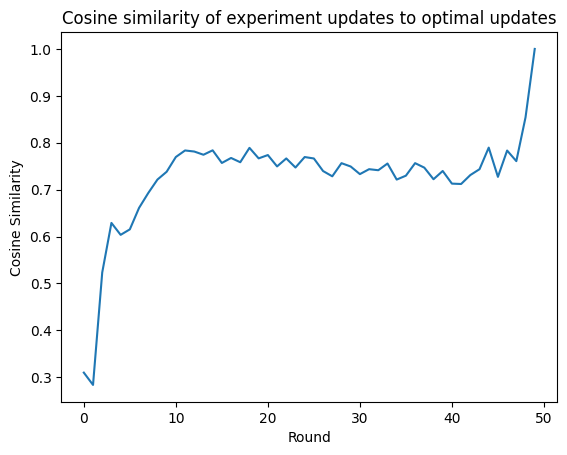

In [65]:
# Question 9, parts 1,2,3

previous_parameters = flatten(parameters_for_each_round[0][1])[0]
final_parameters = flatten(parameters_for_each_round[-1][1])[0]
cosine_similarity_results = []
gradients = []

for i, parameters in parameters_for_each_round[1:]:
    updated_parameters = flatten(parameters)[0]
    # The gradient is the difference between the parameters
    g_t = updated_parameters - previous_parameters
    # The optimal direction is the pseudogradient towards the final model
    optimal_direction = final_parameters - previous_parameters
    # Calculate the cosine similarity
    cosine_similarity_results.append(cosine_similarity(g_t, optimal_direction))
    # Auxiliary output information
    gradients.append(g_t)
    # Crucial step
    previous_parameters = updated_parameters

fig, ax = plt.subplots()
ax.set_title("Cosine similarity of experiment updates to optimal updates")
ax.set_xlabel("Round")
ax.set_ylabel("Cosine Similarity")
ax.plot(cosine_similarity_results)

print(cosine_similarity_results)


4. What do you observe from the plots? Does every update point in the direction of the final model? If not, why do you think that is?

Two primary effects can be observed
1. On all epochs, the recorded cosine similarity towards the optimal gradient update is positive, from an initial similarity of $0.315$.
2. The cosine similarity is generally increasing, with fast improvements at the start and end (and a plateau in the center)

The first impact demonstrates that all training rounds are useful, in that they move the model towards the 'correct' direction.

The second shows that as we obtain a better model, the training direction becomes more consistent towards a unified direction. At the beginning, our model trains from a purely random model with uncertain gradient direction towards a more stable 'useful' model. The final increase may be an artifact of our definition of the 'optimal mode' - eg. for the last few rounds I expect that the gradient landscape is similar, and by definition the last round must have a similarity of $1$.

Another effect that can be observed is the long plateau between rounds $10$ and $45$ - perhaps gradient updates occur in a similar direction?

From the figure below, we observe that after round $10$ it is indeed the case that gradient updates between rounds have relatively high cosine similarities, with a cosine similarity of $0.5$ indicating a $\theta = \frac{\pi}{6}$ degree similarity ($\frac{\pi}{3}$ difference) between the updates. This would motivate the momentum used in the followup question.

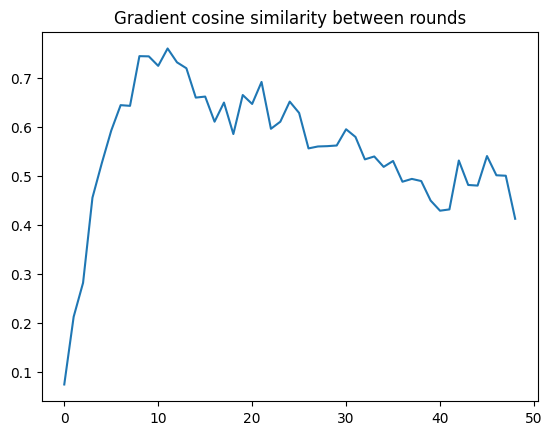

In [67]:
gradient_similarity_plot = []
for i, g in enumerate(gradients[1:]):
    gradient_similarity_plot.append(
        cosine_similarity(g, gradients[i-1])
    )
fig, ax = plt.subplots()
ax.set_title("Gradient cosine similarity between rounds")
ax.plot(gradient_similarity_plot)

**Question 10 (Part III/MPhil ✅):**

(You must provide the answer with **code** and **plots** for this question. A short written argumentation is recommended.)

 and then for

1.   Read about server momentum in FL [here](https://arxiv.org/abs/2003.00295) and repeat the previous experiments using `server_learning_rate=1.0` and `server_momentum=0.9`. Discuss how the momentum impacts the direction of optimization.


